In [2]:
import pandas as pd
from upsetplot import from_contents, UpSet
import matplotlib.pyplot as plt
from cnmf import cNMF
import numpy as np

In [3]:
df_de = pd.read_csv('data/Koenig_DE.csv', index_col=0)

/hpc/home/zy231/.local/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


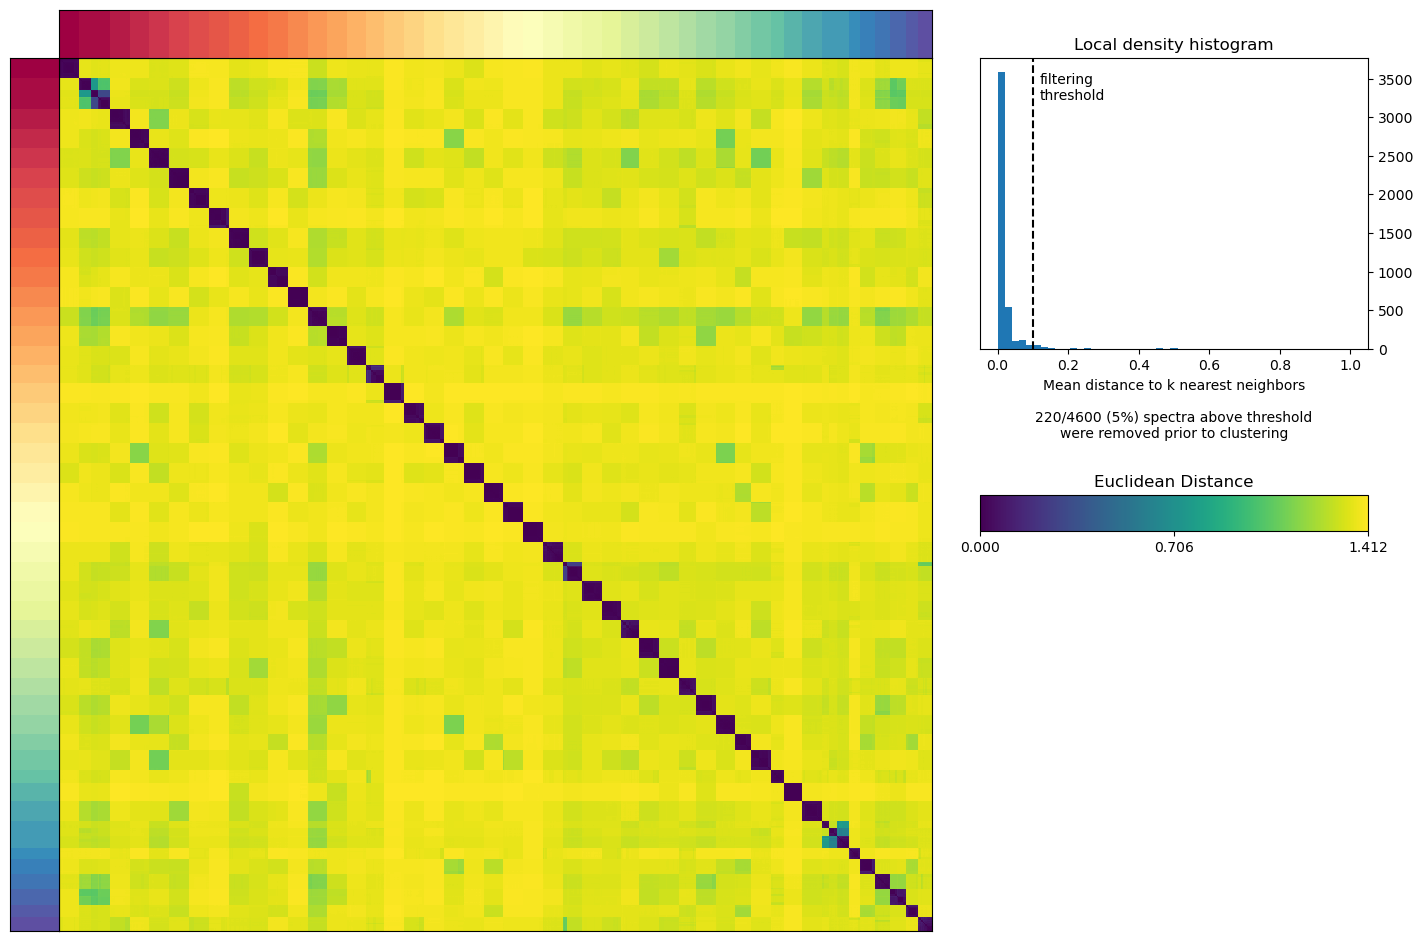

In [4]:
cnmf_obj = cNMF(output_dir="results/cnmf_run", name="4050run")
cnmf_obj.consensus(k=46, density_threshold=0.1)
usage, spectra_scores, spectra_tpm, top_genes = cnmf_obj.load_results(K=46, density_threshold=0.1)

In [5]:
spectra_df = spectra_scores.T 

# 2. Convert Spectra to "Top 50" Gene Sets
top_n = 50
cnmf_program_sets = {}

for program_name in spectra_df.index:
    # Get top 50 genes
    top_genes = spectra_df.loc[program_name].nlargest(top_n).index.tolist()
    
    # Clean values: Force Uppercase strings
    top_genes = [str(g).upper() for g in top_genes]
    
    # FIX IS HERE: Convert the Key (program_name) to a string
    str_program_name = str(program_name)
    
    # Add to dictionary using the string name
    cnmf_program_sets[str_program_name] = top_genes

In [ ]:
#DE and Programs

In [6]:
df_de

,Ensembl ID,Cell Type,Test\nGroup,Reference\nGroup,N Sample:\r\nTest Group,N Sample:\r\nReference Group,N Nuclei:\r\nTest Group,N Nuclei:\r\nReference Group,AVG EXPR:\r\nTest Group,AVG EXPR:\r\nReference Group,PCT > 0:\r\nTest Group,PCT > 0:\r\nReference Group,Background\nContamination\nFlag,CellBender:\r\nlogFC,CellBender:\r\nP-Value,CellBender:\r\nAdjusted P-Value,CellRanger:\r\nlogFC,CellRanger:\r\nP-Value,CellRanger:\r\nAdjusted P-Value
Gene,,,,,,,,,,,,,,,,,,,
LINC00670,ENSG00000179136,Pseudo-Bulk,DCM,NF,11,16,171996,185441,0.088,0.028,0.079,0.022,NaN,2.43,4.710000e-13,6.980000e-09,2.46,2.840000e-13,2.360000e-09
LCN10,ENSG00000187922,Pseudo-Bulk,DCM,NF,11,16,171996,185441,0.003,0.035,0.001,0.017,NaN,-4.13,1.340000e-12,9.950000e-09,-4.13,3.180000e-13,2.360000e-09
AOX1,ENSG00000138356,Pseudo-Bulk,DCM,NF,11,16,171996,185441,0.017,0.100,0.009,0.051,NaN,-2.89,2.860000e-12,1.410000e-08,-2.85,1.250000e-12,3.690000e-09
SLC11A1,ENSG00000018280,Pseudo-Bulk,DCM,NF,11,16,171996,185441,0.020,0.138,0.008,0.057,NaN,-3.83,4.420000e-12,1.590000e-08,-3.66,1.050000e-12,3.690000e-09
TLL2,ENSG00000095587,Pseudo-Bulk,DCM,NF,11,16,171996,185441,0.268,0.047,0.120,0.040,NaN,2.50,5.460000e-12,1.590000e-08,2.51,5.180000e-12,9.590000e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SYTL2,ENSG00000137501,Cardiomyocyte,DCM,NF,11,16,35416,61125,0.010,0.007,0.014,0.006,0.0,-0.04,9.604000e-01,9.771000e-01,1.00,2.520000e-05,4.870000e-04
TENM4,ENSG00000149256,Cardiomyocyte,DCM,NF,11,16,35416,61125,0.007,0.005,0.010,0.005,1.0,-0.03,9.656000e-01,9.804000e-01,0.65,1.300000e-03,8.500000e-03
CHCHD1,ENSG00000172586,Cardiomyocyte,DCM,NF,11,16,35416,61125,0.016,0.011,0.026,0.013,0.0,-0.03,9.690000e-01,9.826000e-01,-0.62,8.180000e-06,2.230000e-04


In [6]:
# ==========================================
# 1. SETUP YOUR LISTS
# ==========================================

def clean_set(gene_list):
    return list(set(gene_list))

# A. Define your Patient Splits (The "Reference" Truth)
# Assuming 'df_de' is your DE dataframe loaded earlier
up_genes = df_de[
    (df_de['log2FoldChange'] > 0) & (df_de['padj'] < 0.05)
].index.str.upper().tolist()

down_genes = df_de[
    (df_de['log2FoldChange'] < 0) & (df_de['padj'] < 0.05)
].index.str.upper().tolist()

# B. Define your cNMF Programs (The "Queries")
# You can pick just the interesting ones to keep the plot readable
# B. Target Programs
target_programs = np.arange(1,47)
target_programs.sort()

# C. Build Dictionary & Remove Duplicates immediately
gene_sets = {
    'Patient_UP': clean_set(up_genes),       # <--- FIX APPLIED HERE
    'Patient_DOWN': clean_set(down_genes)    # <--- FIX APPLIED HERE
}

for p in target_programs:
    # Key matching logic
    p_str, p_int = str(p), int(p) if str(p).isdigit() else None
    
    if p_str in cnmf_program_sets:
        gene_sets[f"Prog_{p}"] = clean_set(cnmf_program_sets[p_str]) # <--- FIX
    elif p_int in cnmf_program_sets:
        gene_sets[f"Prog_{p}"] = clean_set(cnmf_program_sets[p_int]) # <--- FIX

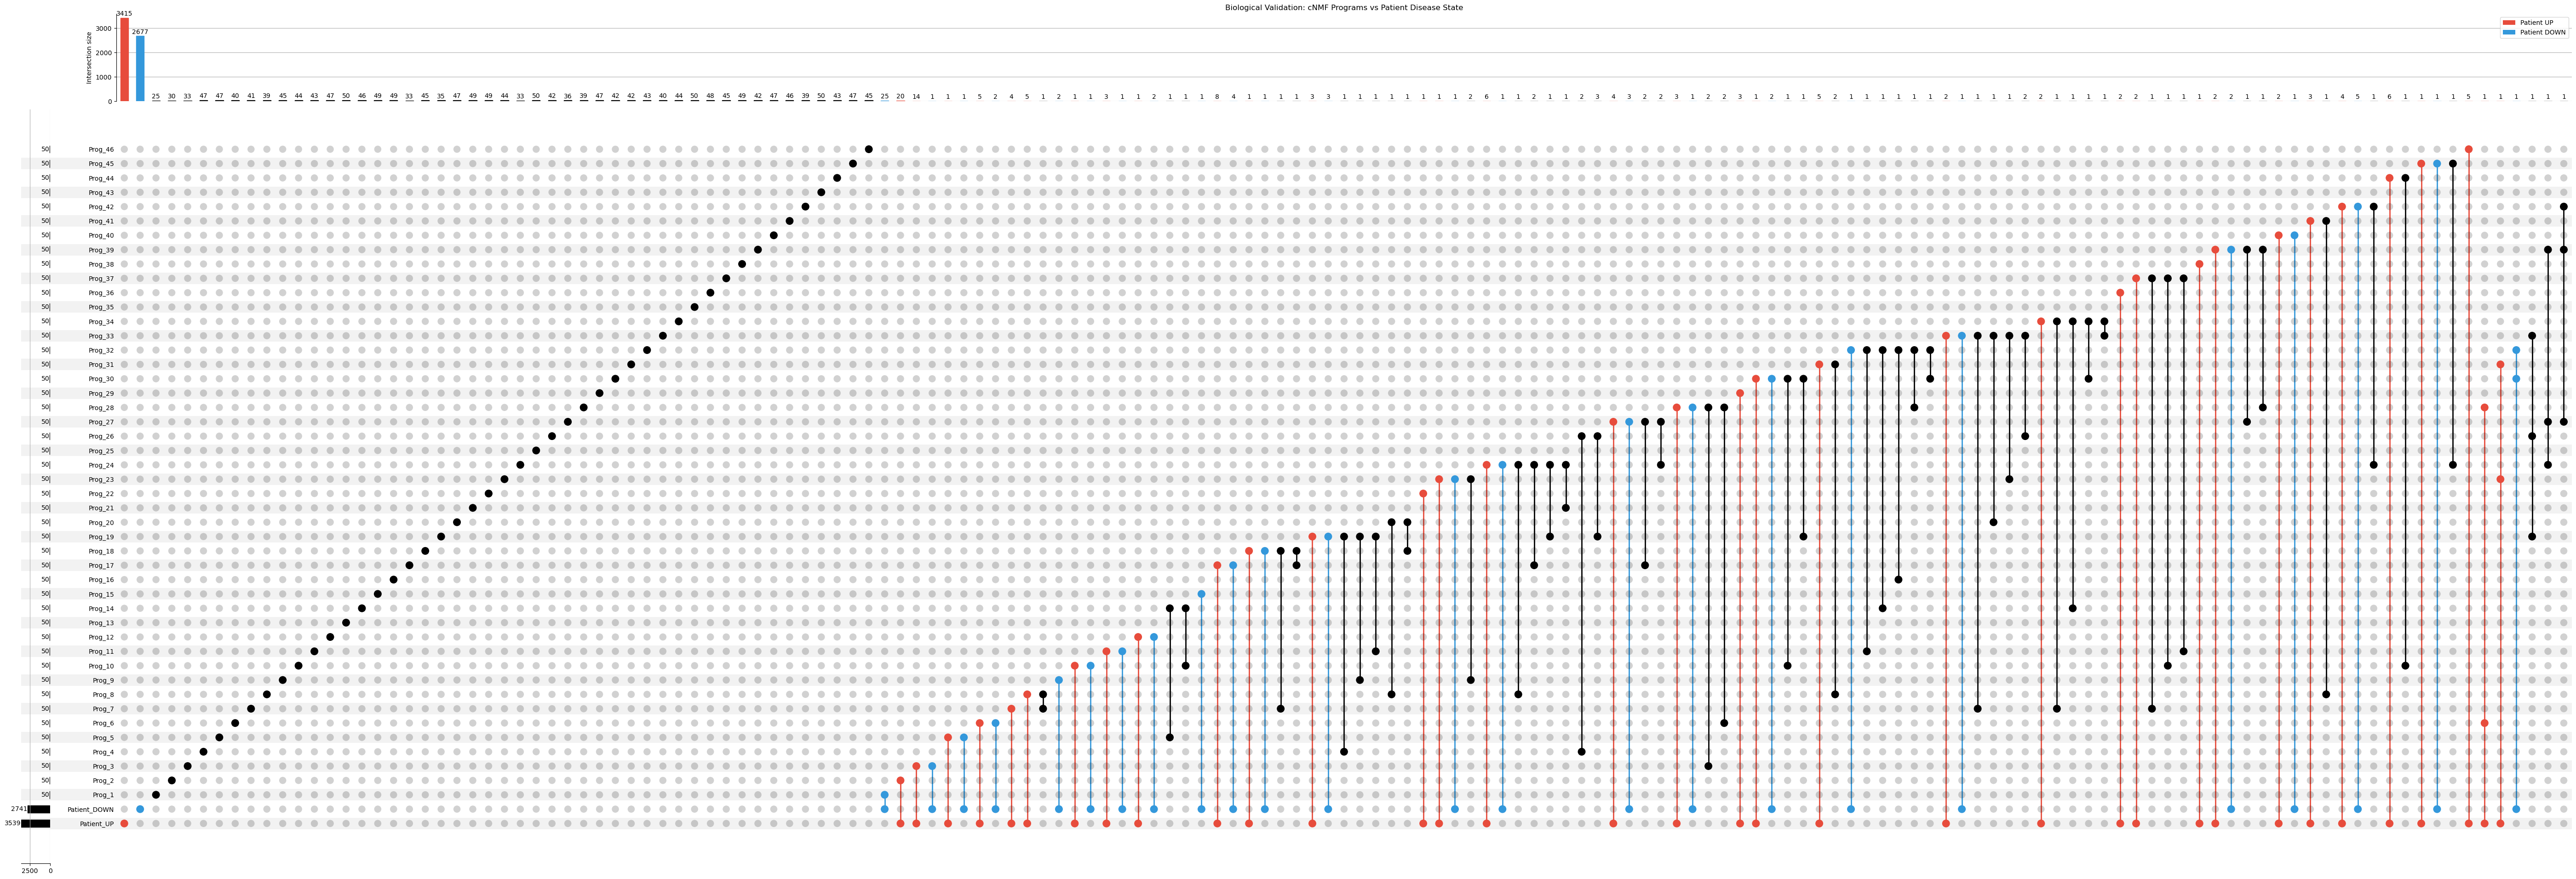

In [16]:
# ==========================================
# 2. GENERATE THE UPSET PLOT
# ==========================================

# Now this should run without error
content = from_contents(gene_sets)

plot = UpSet(content, subset_size='count', show_counts=True, min_subset_size=1)
plot.style_subsets(present='Patient_UP', facecolor='#e74c3c', label='Patient UP')
plot.style_subsets(present='Patient_DOWN', facecolor='#3498db', label='Patient DOWN')

fig = plt.figure(figsize=(12, 6))
plot.plot(fig=fig)

plt.title("Biological Validation: cNMF Programs vs Patient Disease State")
plt.savefig('all_koenig_DE_program_upset.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#Program to Program

<Figure size 1200x600 with 0 Axes>

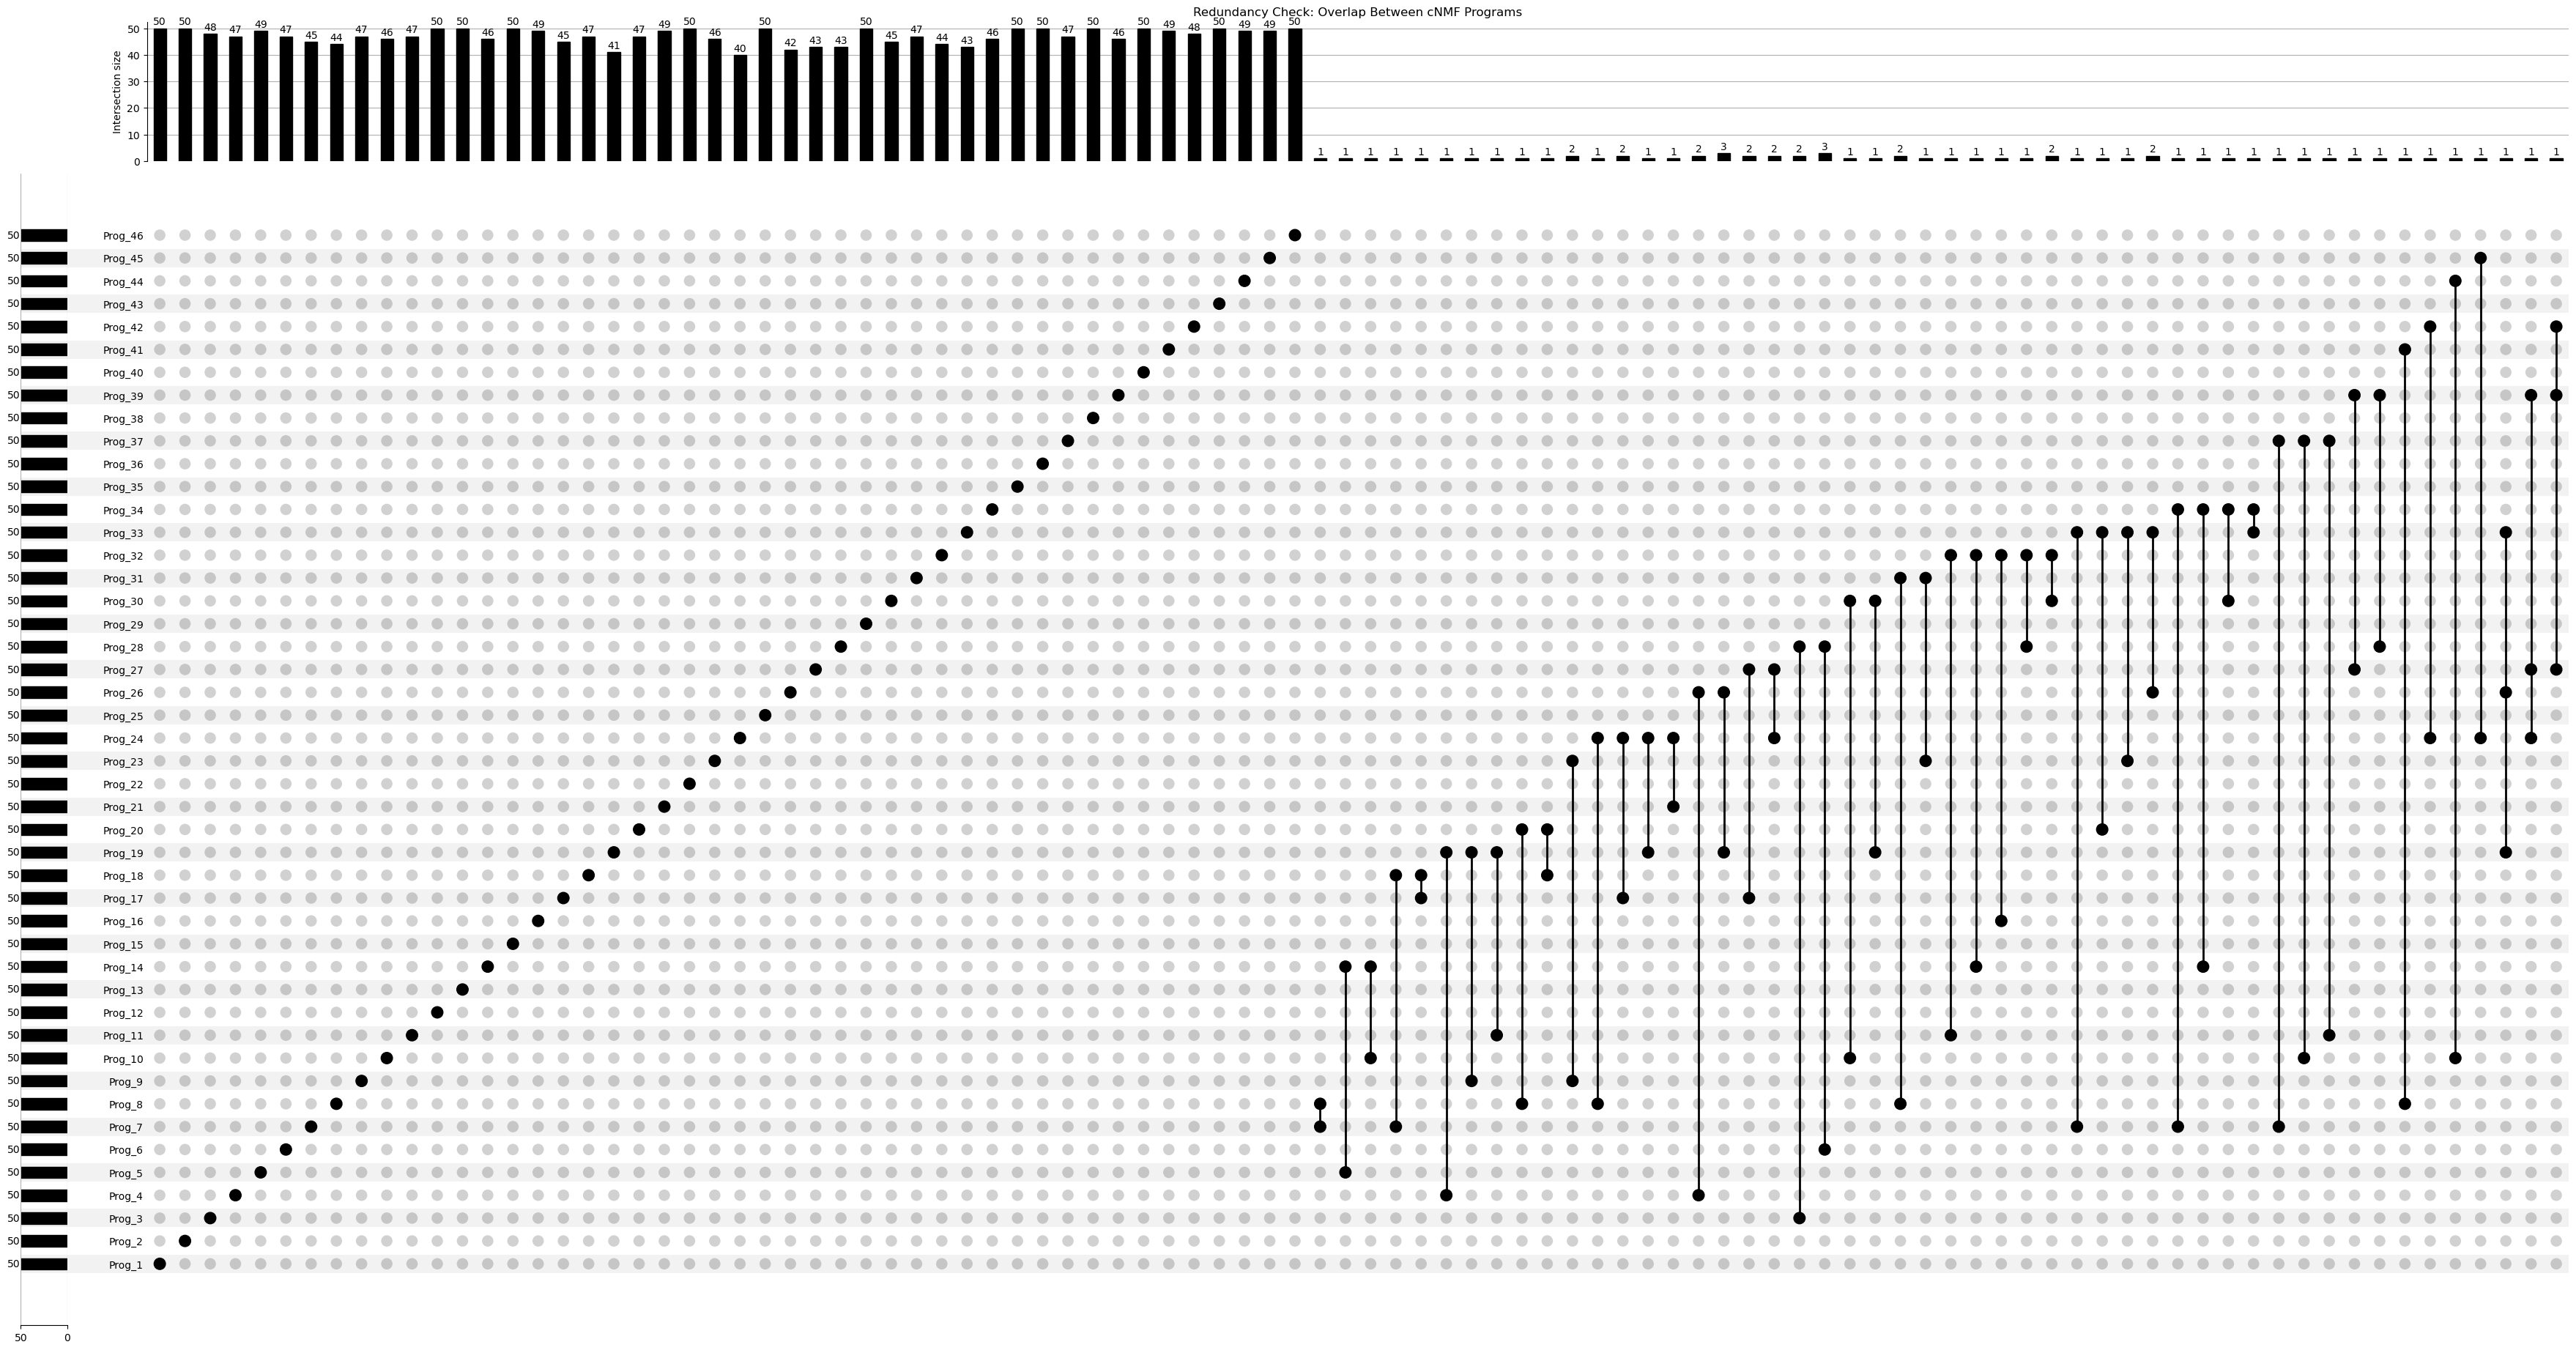

In [9]:


# 1. Select the programs you want to compare
# These keys must match your cnmf_program_sets dictionary
programs_to_compare = np.arange(1, 47).astype(str).tolist()

# 2. Build the dictionary
# We simply pull the lists from your existing cnmf_program_sets
plot_data = {}
for p in programs_to_compare:
    if p in cnmf_program_sets:
        plot_data[f"Prog_{p}"] = cnmf_program_sets[p]

# 3. Generate the UpSet Plot
# from_contents calculates all the intersections for you
content = from_contents(plot_data)

# 'min_subset_size=1' hides intersections that have 0 genes
plot = UpSet(content, subset_size='count', show_counts=True, min_subset_size=1)

# 4. Save and Show
plt.figure(figsize=(12, 6))
plot.plot()
plt.title("Redundancy Check: Overlap Between cNMF Programs")
plt.savefig('cNMF_Program_Redundancy.png', dpi=300, bbox_inches='tight')
plt.show()

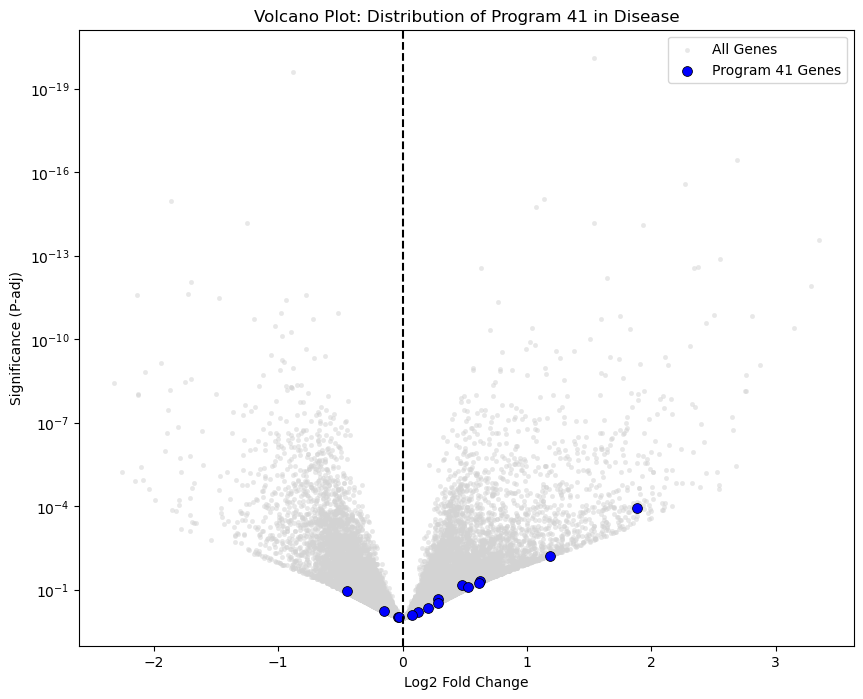

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Setup Data
# Ensure you have your DE dataframe (df_de) and program dictionary (cnmf_program_sets)
# Let's focus on your star program: 41
prog_name = '41'
# Handle the key format (str vs int)
prog_genes = cnmf_program_sets.get('41') or cnmf_program_sets.get(41)

# 2. Create the Volcano Plot
plt.figure(figsize=(10, 8))

# A. Plot Background (All Genes) - Grey
sns.scatterplot(
    data=df_de, 
    x='log2FoldChange', 
    y='padj', 
    color='lightgrey', 
    alpha=0.5, 
    s=10, 
    edgecolor=None,
    label='All Genes'
)

# B. Plot Program Genes - Colored
# Filter for genes in the program
prog_df = df_de[df_de.index.str.upper().isin(prog_genes)]

sns.scatterplot(
    data=prog_df,
    x='log2FoldChange',
    y='padj',
    color='blue',  # Blue for downregulation
    s=50,          # Make them bigger
    edgecolor='black',
    label=f'Program {prog_name} Genes'
)

# 3. Beautify
# Convert P-value to -log10 scale for standard volcano look
plt.yscale('log')
plt.gca().invert_yaxis() # Small p-value = High up
plt.ylabel('Significance (P-adj)')
plt.xlabel('Log2 Fold Change')
plt.title(f'Volcano Plot: Distribution of Program {prog_name} in Disease')
plt.axvline(0, color='black', linestyle='--')
plt.legend()

plt.savefig(f'Volcano_Program_{prog_name}.png', dpi=300)
plt.show()

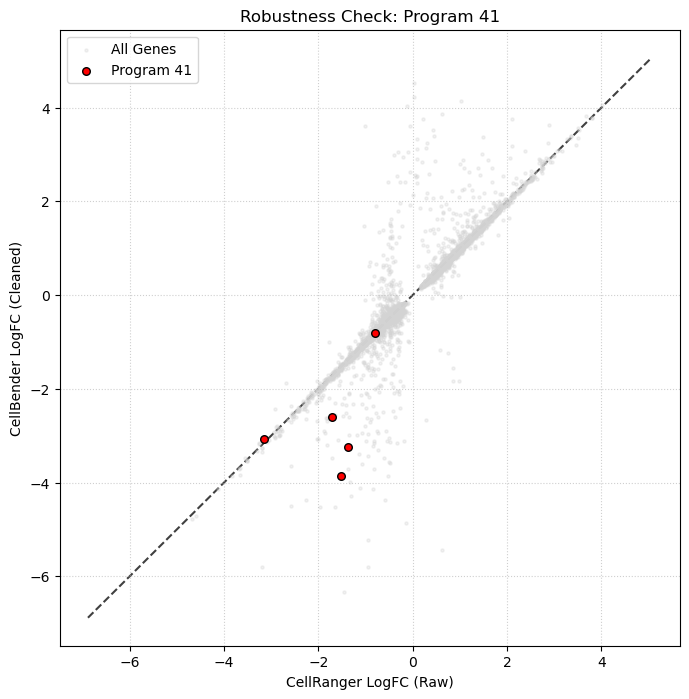

In [11]:
df_de = pd.read_csv('data/chaffin_DE.csv', index_col = 0)

plt.figure(figsize=(8, 8))

# 1. Plot all genes (Background)
plt.scatter(
    df_de['CellRanger:\r\nlogFC'], 
    df_de['CellBender:\r\nlogFC'], 
    c='lightgrey', 
    alpha=0.3, 
    s=5, 
    label='All Genes'
)

# 2. Plot Program 41 Genes (Highlight)
# Filter for genes in program 41 that exist in the dataframe
prog_indices = [g for g in prog_genes if g in df_de.index.str.upper()]
prog_df_scatter = df_de.loc[df_de.index.str.upper().isin(prog_indices)]

plt.scatter(
    prog_df_scatter['CellRanger:\r\nlogFC'], 
    prog_df_scatter['CellBender:\r\nlogFC'], 
    c='red', 
    s=30, 
    edgecolor='black', 
    label=f'Program {prog_name}'
)

# 3. Add diagonal line (Perfect agreement)
lims = [
    np.min([plt.xlim(), plt.ylim()]),  # min of both axes
    np.max([plt.xlim(), plt.ylim()]),  # max of both axes
]
plt.plot(lims, lims, 'k--', alpha=0.75, zorder=0)

plt.xlabel('CellRanger LogFC (Raw)')
plt.ylabel('CellBender LogFC (Cleaned)')
plt.title(f'Robustness Check: Program {prog_name}')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)

plt.savefig(f'Robustness_Scatter_{prog_name}.png', dpi=300)
plt.show()